## Setup

In [1]:
# Standard imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dill
import json
import os

from scipy.stats import pearsonr

import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import nn

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

from sklearn import metrics as skmetrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# Custom utilities imports
sys.path.append("/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Modules")
from modeling import Dataset, Results, Model, ModelWithAutoencoders, ModelAnalysis
import architectures

## Load data

In [3]:
# Load dataset
filepath = "../../Data/Preprocessed Datasets/"
with open(filepath + "GDSC-KINOMEscan_proteins_intersection_+_remaining_GDSC_target_genes_dataset.pkl", "rb") as f:
    full_dataset = dill.load(f)
print(full_dataset.name, type(full_dataset))
print()
print(full_dataset.description)
print(full_dataset.full_cell_lines_data.shape, full_dataset.drugs_data.shape)

Kinases Dataset + Remaning GDSC drug's putative targets <class 'modeling.Dataset'>

Dataset containing 74 common drugs of GDSC and HMS LINCS Kinome scan dataset.
Cell lines data types: expression, coding variant and tissue type. Expressions and coding variants are 
present only for proteins present in both GDSC and KINOMEscan data, resulting in expression of 188 genes and
nmutations in 18 genes.
In addition, expressions and mutations (17 new features) of remaining target genes from GDSC are included
Tissue types are dummy encoded GDSC Tissue Descriptions 1 (18 features).
Drugs representation: inhibition scores (% control) of 294 proteins. Set of proteins is the intersection of 
proteins screened for each of 74 drugs.
Drug response data: drug reponse data contains AUC metrics across cell lines for 74 drugs considered.
(922, 242) (74, 294)


In [4]:
# Preprocess
# Establish response data for samples (drug-cell line pairs)
response_df = full_dataset.response_data.copy()

# Establish cell line features data
cell_line_data_original_df = full_dataset.full_cell_lines_data.copy()

# Search for cell lines present in response data, but missing the genomic features
missing_cell_lines = []
for cosmic_id in response_df.COSMIC_ID.unique():
    if cosmic_id not in cell_line_data_original_df.cell_line_id.unique():
        missing_cell_lines.append(cosmic_id)
# Put cell line IDs into index and drop cell line IDs columns
cell_line_data_original_df.index = cell_line_data_original_df.cell_line_id
cell_line_data_original_df = cell_line_data_original_df.drop("cell_line_id", axis=1)

# Extract response only for cell lines for which features are present
response_df = response_df[~response_df.COSMIC_ID.isin(missing_cell_lines)]

# Establish drug features data
drug_data_original_df = full_dataset.drugs_data.copy()

# Convert drug index from LINCS name to GDSC drug ID
drug_data_original_df.index = drug_data_original_df.index.map(full_dataset.kinomescan_name_to_gdsc_id_mapper)

# Establish how many cells go to train/val/test sets
num_val_cell_lines = 100
num_test_cell_lines = 100

print(drug_data_original_df.shape, cell_line_data_original_df.shape)

(74, 294) (922, 241)


## Display considered pipelines

In [5]:
! ls "../Model development/Results/Pipeline evaluations/"

'Non-weigted loss without exclusion, two-layer code forwarding - architecture tuning'
'Non-weigted loss without exclusion, two-layer code forwarding - architecture tuning-20200406T091511Z-001.zip'


In [6]:
pipelines_dir = "../Model development/Results/Pipeline evaluations/"

## Learning curve for a best model on test data for a given setup

In [7]:
def best_models_learning_curve(Pipeline, Experiment, metric1, metric2, mode):
    results_dir = os.path.join(pipelines_dir, Pipeline)
    results = Results(results_dir)
    df = results.get_best_model_learning_curve(Experiment)
    if mode == "max":
        best_metric1 = df[metric1].max()
        if metric2:
            best_metric2 = df[metric2].max()
        else:
            best_metric2 = None
    else:
        best_metric1 = df[metric1].min()
        if metric2:
            best_metric2 = df[metric2].min()
        else:
            best_metric2 = None
    # Print best params
    results.get_best_params(Experiment)
    print()
    print("Best", metric1, np.round(best_metric1, 3))
    print("Best", metric2, np.round(best_metric2, 3))
    Results.plot_learning_curve(df, metric1, metric2, title=Pipeline)

metrics = ["loss", "train_rmse", "train_corr", "train_median_rmse", "train_median_corr", 
          "test_rmse", "test_corr", "test_median_rmse", "test_median_corr"]

other_metrics = ["train_drug_rec_rmse", "train_cl_rec_rmse", "test_drug_rec_rmse", "test_cl_rec_rmse",
                          "train_drug_rec_corr", "train_cl_rec_corr", "test_drug_rec_corr", "test_drug_cl_corr",
                 "drug_independence_train_loss", "cl_independence"]
metrics = ["train_loss", "train_y_loss"] + metrics

metrics = ["train_loss", "train_y_loss", "train_rmse", "train_corr", "train_median_rmse", "train_median_corr", 
          "test_rmse", "test_corr", "test_median_rmse", "test_median_corr"]

interact(best_models_learning_curve,
         Pipeline=os.listdir(pipelines_dir),
         Experiment=range(1, 6),
         metric1=metrics + other_metrics[-2:],
         metric2=metrics + other_metrics[-2:] + [None],
         mode=["max", "min"])

plt.show()

interactive(children=(Dropdown(description='Pipeline', options=('Non-weigted loss without exclusion, two-layer…

## Validation results for a given parameter combination

## Load trained system

#### Load state dict of trained model

In [45]:
# ! ls "../Model development/Results/Final evaluations/One-hidden layer autoencoders/Experiment 1"

In [46]:
def load_best_models_state_dict(Pipeline, Experiment):
    exp_dir = os.path.join(pipelines_dir, Pipeline, "Experiment " + str(Experiment))
    state_dict = torch.load(os.path.join(exp_dir, "best_network_state_dict.pth"), 
                            map_location=torch.device('cpu'))
    print(os.path.join(exp_dir, "best_network_state_dict.pth"))
    # Print corresponding hyperparameters
    print()
    with open(os.path.join(exp_dir, "best_config.txt"), "r") as f:
        print(f.read())
    return state_dict, Experiment

load_best_models_state_dict_widget = interactive(load_best_models_state_dict,
           Pipeline=os.listdir(pipelines_dir),
           Experiment=range(1, 6))
display(load_best_models_state_dict_widget)

interactive(children=(Dropdown(description='Pipeline', options=('Non-weigted loss without exclusion, two-layer…

In [10]:
state_dict, experiment = load_best_models_state_dict_widget.result
print(type(state_dict), experiment)

<class 'collections.OrderedDict'> 1


#### Establish new raw network with autoencoders and load state dict

In [47]:
torch.manual_seed(11)
def establish_new_system(drug_dim, cell_line_dim, code_dim, architecture_type,
                    num_layers, drug_hidden_dim1, drug_hidden_dim2, drug_hidden_dim3,
                    cell_line_hidden_dim1, cell_line_hidden_dim2, cell_line_hidden_dim3,
                     dropout, dropout_rate, code_activation, activation_func, out_activation,
                        batch_norm):
    # Establish specs
    specs = {"drug_dim": drug_dim,
            "cell_line_dim": cell_line_dim,
            "code_dim": code_dim,
            "architecture_type": architecture_type,
            "num_layers": num_layers,
            "drug_hidden_dim1": drug_hidden_dim1,
            "drug_hidden_dim2": drug_hidden_dim2,
            "drug_hidden_dim3": drug_hidden_dim3,
            "cell_line_hidden_dim1": cell_line_hidden_dim1,
            "cell_line_hidden_dim2": cell_line_hidden_dim2,
            "cell_line_hidden_dim3": cell_line_hidden_dim3,
            "dropout": dropout,
            "dropout_rate": dropout_rate,
            "code_activation": code_activation,
            "activation_func": activation_func,
            "out_activation": out_activation,
            "batch_norm": batch_norm}
    
    
    network = ModelAnalysis.instantiate_system(specs)
    return network

establish_new_system_widget = interactive(establish_new_system,
                                     drug_dim=[294],
                                     cell_line_dim=[241, 1144],
                                     code_dim=widgets.IntSlider(value=10, min=2, max=30),
                                     architecture_type=["autoencoders", "linear"],
                                     num_layers=[1, 2, 3, None],
                                     drug_hidden_dim1=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     drug_hidden_dim2=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     drug_hidden_dim3=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     cell_line_hidden_dim1=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     cell_line_hidden_dim2=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     cell_line_hidden_dim3=widgets.BoundedIntText(value=128, min=16, max=2048),
                                     dropout=[False, True],
                                     dropout_rate=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.05),
                                     code_activation=[False, True],
                                     activation_func=[nn.ReLU, nn.Tanh, nn.SELU],
                                     out_activation=[torch.sigmoid, None],
                                     batch_norm=[False, True])
display(establish_new_system_widget)

interactive(children=(Dropdown(description='drug_dim', options=(294,), value=294), Dropdown(description='cell_…

In [48]:
# MUST EXECUTE ALSO
network = establish_new_system_widget.result
print(network.out_activation)
network

<built-in method sigmoid of type object at 0x7f1c8d039640>


RecSystemWithAutoencoders(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=241,

In [ ]:
# Load state dict if needed
print(next(network.parameters()).sum())
network.load_state_dict(state_dict)
model = ModelWithAutoencoders("Example", network)
print(next(network.parameters()).sum())

#### Add code forwarding if needed

In [49]:
# Modify network to add forward propagation of codes if needed
def forward_network_specs(model_type, num_layers, code_interactions, code_dim,
                         out_activation, forward_net_hidden_dim1,
                         forward_net_hidden_dim2, drop_rate):
    if model_type == "linear":
        if code_interactions:
            m = architectures.ForwardLinearRegression(code_dim ** 2 + 2 * code_dim, 
                                            out_activation=out_activation)
        else:
            m = architectures.ForwardLinearRegression(2 * code_dim, 
                                                      out_activation=out_activation)
    else:
        if code_interactions:
            if num_layers == 1:
                m = architectures.ForwardNetworkOneHiddenLayer(code_dim ** 2 + 2 * code_dim,
                                                          forward_net_hidden_dim1,
                                                          dropout_rate=drop_rate,
                                                          out_activation=out_activation)
            elif num_layers == 2:
                m = architectures.ForwardNetworkTwoHiddenLayers(code_dim ** 2 + 2 * code_dim,
                                                          forward_net_hidden_dim1,
                                                          forward_net_hidden_dim2,
                                                          dropout_rate=drop_rate,
                                                          out_activation=out_activation)
        else:
            if num_layers == 1:
                m = architectures.ForwardNetworkOneHiddenLayer(2 * code_dim,
                                                          forward_net_hidden_dim1,
                                                          dropout_rate=drop_rate,
                                                          out_activation=out_activation)
            elif num_layers == 2:
                m = architectures.ForwardNetworkTwoHiddenLayers(2 * code_dim,
                                                          forward_net_hidden_dim1,
                                                          forward_net_hidden_dim2,
                                                          dropout_rate=drop_rate,
                                                          out_activation=out_activation)
    return m, code_interactions

forward_net_specs_widget = interactive(forward_network_specs,
                                       model_type=["linear", "nn"],
                                       num_layers=[1, 2, 3],
                                       code_interactions=[False, True],
                                       code_dim=widgets.IntSlider(value=10, min=2, max=30),
                                       out_activation=[None, torch.sigmoid],
                                       forward_net_hidden_dim1=widgets.BoundedIntText(value=128, min=16, max=2048),
                                       forward_net_hidden_dim2=widgets.BoundedIntText(value=128, min=16, max=2048),
                                       drop_rate=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.05))
                                       
display(forward_net_specs_widget)

interactive(children=(Dropdown(description='model_type', options=('linear', 'nn'), value='linear'), Dropdown(d…

In [50]:
# Establish rec system with forward code propagation
m, code_interactions = forward_net_specs_widget.result
drug_autoencoder = network.drug_autoencoder
cl_autoencoder = network.cell_line_autoencoder
network = architectures.RecSystemCodeConcatenation(drug_autoencoder, cl_autoencoder, forward_network=m,
                                          code_interactions=code_interactions)
print(next(network.parameters()).sum())
# Load state dict
network.load_state_dict(state_dict)
print(next(network.parameters()).sum())
model = ModelWithAutoencoders("Example", network)
network

tensor(-7.9153, grad_fn=<SumBackward0>)
tensor(15.9032, grad_fn=<SumBackward0>)


RecSystemCodeConcatenation(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=241

#### Establish data

In [51]:
split_seeds_all = [40, 65, 31, 9, 27]
split_seed = split_seeds_all[experiment - 1]   # ESTABLISH SPLIT SEED
print(split_seed)

40


In [52]:
# Split data into train/val/test sets
samples_train, samples_val, samples_test, cell_lines_test, cell_lines_val = Dataset.samples_train_test_split(
                                                                        response_df,
                                                                        num_val_cell_lines,
                                                                        num_test_cell_lines,
                                                                        split_seed,
                                                                        shuffle=True)
# Merge training and validation samples
samples_train_and_val = pd.concat([samples_train, samples_val], axis=0)
                                                                       
# Normalize the data
# Cell line data
cols_subset = [col for col in list(cell_line_data_original_df) if col.endswith("_exp")]
rows_subset = [x for x in cell_line_data_original_df.index if x not in cell_lines_test + cell_lines_val]

cell_line_data_df = Dataset.standardize_data(cell_line_data_original_df, cols_subset=cols_subset,
                                            rows_subset=rows_subset)
# Drug data
drug_data_df = Dataset.standardize_data(drug_data_original_df)

## Investigate loaded model

### Evaluate predictions of loaded model

#### General results

In [53]:
# Evaluation on test set
samples = samples_test.copy()
print("Test data")
print()
# Make predictions
# Linear model case
if model.__class__ == Model:
    response_preds, y_true = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    print(response_preds.shape, y_true.shape)
# Model with autoencoders case
elif model.__class__ == ModelWithAutoencoders:
    predicted, y_true, drug_input, cl_input = model.predict(samples, cell_line_data_df,
                                                           drug_data_df)
    response_preds, drug_rec_preds, cl_rec_preds = predicted
    print(response_preds.shape, y_true.shape, drug_input.shape, cl_input.shape)

# Create a dataframe with samples and corresponding predictions
samples_with_predictions_val_df = samples.copy()
samples_with_predictions_val_df.insert(3, "Predicted AUC", response_preds.reshape(-1))
print(samples_with_predictions_val_df.shape)

# Evaluate predictions numerically
rmse, corr = Model.evaluate_predictions(y_true, response_preds.numpy().reshape(-1))
print("Response prediction performance:")
print("RMSE: {}, Corr.: {}".format(rmse, corr))

per_drug_performance_val_df = Model.per_drug_performance_df(samples, response_preds)
print(per_drug_performance_val_df.shape)
per_drug_performance_val_df.insert(1, "Drug name", per_drug_performance_val_df["Drug ID"].map(
    full_dataset.gdsc_drug_id_to_gdsc_name_mapper))
print(per_drug_performance_val_df.shape)
per_drug_performance_val_df = per_drug_performance_val_df.sort_values("Model correlation", ascending=False)
print("Per drug median RMSE and correlation:", per_drug_performance_val_df["Model RMSE"].median(),
     per_drug_performance_val_df["Model correlation"].median())
print()


# Evaluate reconstruction predictions
# Metrics calculated on whole matrix
rmse, corr = Model.evaluate_predictions(drug_input.ravel(), drug_rec_preds.numpy().ravel())
print("Reconstruction performance:")
print("Whole drug data RMSE and correlation:", np.round(rmse, 3), corr)
rmse, corr = Model.evaluate_predictions(cl_input.ravel(), cl_rec_preds.numpy().ravel())
print("Whole cell line data RMSE and correlation:", np.round(rmse, 3), corr)

per_drug_performance_val_df.head(2)

Test data

torch.Size([5760, 1]) (5760,) (5760, 294) (5760, 241)
(5760, 4)
Response prediction performance:
RMSE: 0.11289051849574688, Corr.: (0.7781633123047875, 0.0)


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(74, 6)
(74, 7)
Per drug median RMSE and correlation: 0.09705043909202002 0.3654335995507535

Reconstruction performance:
Whole drug data RMSE and correlation: 0.299 (0.9534120786023029, 0.0)
Whole cell line data RMSE and correlation: 0.73 (0.6213208729991326, 0.0)


,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
46,301,PHA-793887,0.124742,0.731182,0.182208,NaN,95
11,257,NPK76-II-72-1,0.097686,0.703508,0.122899,NaN,95


#### Per-drug results

#### Per cell-line results

In [54]:
per_cell_line_performance_val_df = Model.per_entity_performance_df(
    samples, response_preds, entity_type="COSMIC_ID")
per_cell_line_performance_val_df = per_cell_line_performance_val_df.sort_values("Model correlation", 
                                                                                ascending=False)
print(per_cell_line_performance_val_df.shape)
print("Per cell line median RMSE and correlation:", 
      per_cell_line_performance_val_df["Model RMSE"].median(),
      per_cell_line_performance_val_df["Model correlation"].median())

/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(100, 6)
Per cell line median RMSE and correlation: 0.10515531812568117 0.8091818686526872


### Investigate the predictions

### Compute reconstructions and code embeddings for drugs and cell lines

In [55]:
# Compute reconstructions for drug
drug_codes, drug_recs = network.drug_autoencoder(torch.from_numpy(drug_data_df.values).float())
print(drug_codes.shape, drug_recs.shape)
# Create a DataFrame with drugs and their code embeddings
drug_codes_df = pd.DataFrame(drug_codes.detach().numpy(), index=drug_data_df.index)
print(drug_codes_df.shape)
drug_codes_df.head(2)

torch.Size([74, 10]) torch.Size([74, 294])
(74, 10)


,0,1,2,3,4,5,6,7,8,9
Small Molecule,,,,,,,,,,
1242,-0.057314,0.386296,-1.059275,0.104523,0.648490,-0.271721,1.075960,0.337390,-0.086636,-0.595830
86,2.181150,-0.137569,0.215287,-0.967331,0.665292,-0.120352,-0.677082,-0.776931,-0.199305,-0.929677


In [56]:
# Per-drug reconstruction performance
drug_rec_performance_df = ModelAnalysis.per_object_reconstruction_evaluations(drug_data_df,
                                                                             drug_recs)
print(drug_rec_performance_df.shape, drug_rec_performance_df["Correlation"].median(),
     drug_rec_performance_df["RMSE"].median())
drug_rec_performance_df.head(3)

(74, 4) 0.8976899374838707 0.29760233324903845


,Object ID,Correlation,Corr. pval,RMSE
0,1242,0.948950,2.343074e-148,0.263253
1,86,0.986234,2.829041e-230,0.252325
2,29,0.890255,9.710806e-102,0.485047


In [59]:
# Compute reconstructions for cell lines
cl_codes, cl_recs = network.cell_line_autoencoder(torch.from_numpy(
    cell_line_data_df.values).float())
print(cl_codes.shape, cl_recs.shape)
cl_codes_df = pd.DataFrame(cl_codes.detach().numpy(), index=cell_line_data_df.index)
print(cl_codes_df.shape)
cl_codes_df.head(2)

torch.Size([922, 10]) torch.Size([922, 241])
(922, 10)


,0,1,2,3,4,5,6,7,8,9
cell_line_id,,,,,,,,,,
906826,0.834057,-0.152405,0.402265,-0.35448,0.101870,0.386494,0.060601,0.595247,0.205199,-0.588315
687983,0.265011,-0.258340,0.687270,0.88900,-0.386147,1.063408,0.440124,-0.490535,-0.169362,-0.159054


In [62]:
# Per-cell line reconstruction performance - all
cl_rec_performance_df = ModelAnalysis.per_object_reconstruction_evaluations(cell_line_data_df,
                                                                             cl_recs)
print(cl_rec_performance_df.shape, cl_rec_performance_df["Correlation"].median(),
     cl_rec_performance_df["RMSE"].median())
cl_rec_performance_df.head(3)

(922, 4) 0.6561052551941233 0.65443996900764


,Object ID,Correlation,Corr. pval,RMSE
0,906826,0.593300,2.621613e-24,0.659749
1,687983,0.617877,9.137184e-27,0.690075
2,910927,0.681221,3.207678e-34,0.692588


In [67]:
cl_rec_performance_df[cl_rec_performance_df["Object ID"].isin(cell_lines_test)]["Correlation"].median()

0.5927051361099742

### Covariance matrices of drug and cell lines code embeddings

torch.Size([74, 10]) torch.Size([922, 10])
(10, 10) (10, 10)


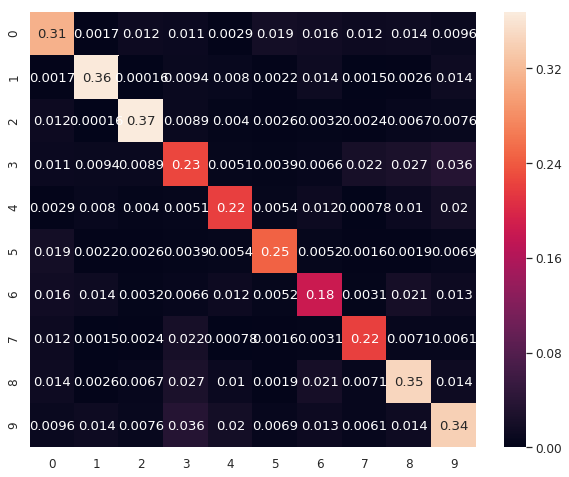

In [68]:
# Compute covariance matrices for drug and cell lines code representations
print(drug_codes.shape, cl_codes.shape)
drug_codes_cov = np.cov(drug_codes.detach().numpy(), rowvar=False)
cl_codes_cov = np.cov(cl_codes.detach().numpy(), rowvar=False)
print(drug_codes_cov.shape, cl_codes_cov.shape)

# Visualize drug representations covariance matrix
sns.set(font_scale=1.1)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(np.abs(drug_codes_cov), annot=True)
ax.tick_params(labelsize=12)

#plt.title("Dependence penalty: 0.15", fontsize=14)

#plt.savefig("cov_matrix_drugs_exp_" + str(experiment) + ".pdf")
plt.show()

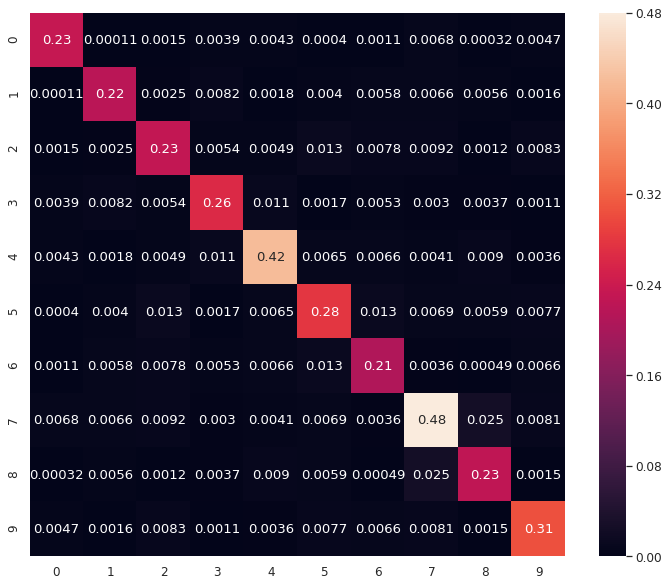

In [69]:
# Visualize cell line representations covariance matrix
sns.set(font_scale=1.1)
plt.figure(figsize=(12, 10))
ax = sns.heatmap(np.abs(cl_codes_cov), annot=True)
ax.tick_params(labelsize=12)

#plt.title("Dependence penalty: 0.15", fontsize=14)

#plt.savefig("cov_matrix_cl_exp_" + str(experiment) + ".pdf")
plt.show()
plt.show()

### Visualize code embeddings in 2D

#### General visualizations

(74, 4)


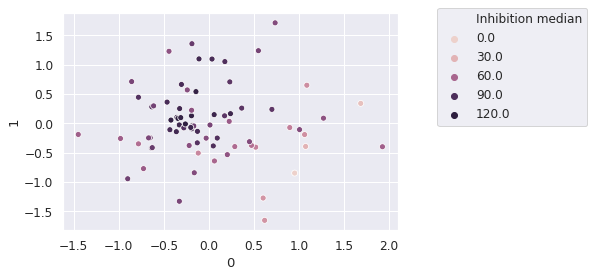

In [34]:
# Visualize drug code representations with PCA
pca = PCA(n_components=2)
codes_embedded = pca.fit_transform(drug_codes.detach().numpy())
# Create a DataFrame with drugs and their 2D embeddings
drug_embeddings_df = pd.DataFrame(codes_embedded, index=drug_codes_df.index)
drug_embeddings_df["TP"] = drug_embeddings_df.index.map(full_dataset.drug_gdsc_id_to_target_pathway_mapper)
drug_embeddings_df["Inhibition median"] = drug_data_original_df.mean(axis=1)
print(drug_embeddings_df.shape)
# Visualize in 2D
sns.scatterplot(x=0, y=1, data=drug_embeddings_df, hue="Inhibition median")
#plt.legend()
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

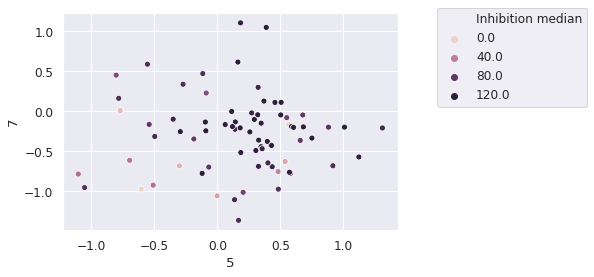

In [35]:
drug_codes_df["TP"] = drug_codes_df.index.map(full_dataset.drug_gdsc_id_to_target_pathway_mapper)
drug_codes_df["Inhibition median"] = drug_data_original_df.median(axis=1)

# Visualize in 2D
sns.scatterplot(x=5, y=7, data=drug_codes_df, hue="Inhibition median")
#plt.legend()
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

(922, 3)


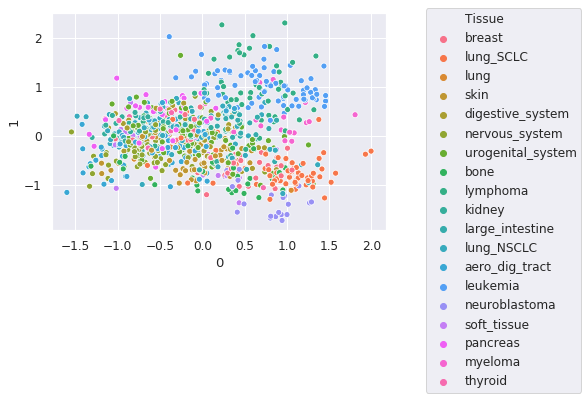

In [36]:
# Visualize cell lines code representations with PCA
pca = PCA(n_components=2)
codes_embedded = pca.fit_transform(cl_codes.detach().numpy())
# Create a DataFrame with drugs and their 2D embeddings
cl_embeddings_df = pd.DataFrame(codes_embedded, index=cl_codes_df.index)
cl_embeddings_df["Tissue"] = cl_embeddings_df.index.map(full_dataset.cl_id_to_tissue_mapper)
print(cl_embeddings_df.shape)
# Visualize in 2D
sns.scatterplot(x=0, y=1, data=cl_embeddings_df, hue="Tissue")

plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()

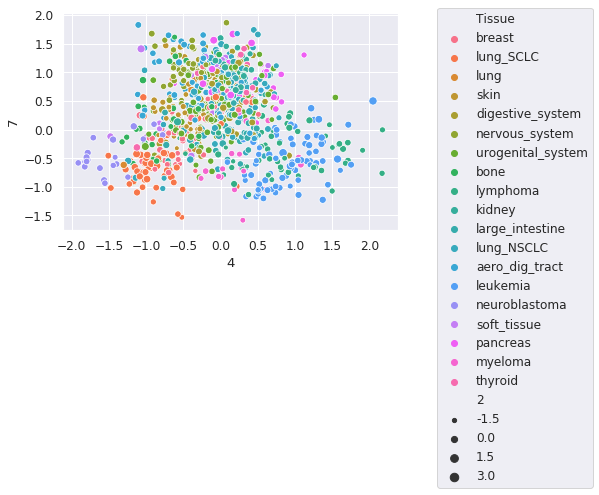

In [37]:
cl_codes_df["Tissue"] = cl_codes_df.index.map(full_dataset.cl_id_to_tissue_mapper)
# Visualize in 2D
sns.scatterplot(x=4, y=7, data=cl_codes_df, hue="Tissue", size=2)
#plt.legend()
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

#### Code visualizations for a given drug

In [70]:
per_drug_performance_val_df.head(2)

,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
46,301,PHA-793887,0.124742,0.731182,0.182208,NaN,95
11,257,NPK76-II-72-1,0.097686,0.703508,0.122899,NaN,95


In [71]:
drug_id = 301
samples = samples_train_and_val[samples_train_and_val["DRUG_ID"] == drug_id]
print(samples.shape)
sampled_cell_lines_codes = cl_codes_df.loc[samples["COSMIC_ID"].values]
sampled_cell_lines_codes["True AUC"] = samples["AUC"].values
print(sampled_cell_lines_codes.shape)
sampled_cell_lines_codes.head(3)

(768, 3)
(768, 11)


,0,1,2,3,4,5,6,7,8,9,True AUC
cell_line_id,,,,,,,,,,,
1240186,0.131163,-0.102191,-0.299807,0.495071,-0.652487,1.171641,-0.259664,0.878918,-0.063970,0.102929,0.964034
908146,-0.607512,0.223031,0.435774,-0.530101,0.480315,0.388391,0.725838,-1.171133,0.881828,-0.223957,0.339799
910780,-0.509465,-0.226320,0.454042,-1.360907,-1.824793,0.035450,0.629567,-0.649211,0.286098,0.000058,0.948755


In [72]:
full_dataset.gdsc_drug_id_to_gdsc_name_mapper[drug_id]

'PHA-793887'

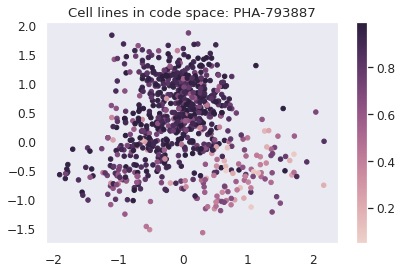

In [73]:
# Visualize by two most variant code dimensions
# Visualize in 2D
cmap = sns.cubehelix_palette(as_cmap=True)

plt.title("Cell lines in code space: " + full_dataset.gdsc_drug_id_to_gdsc_name_mapper[drug_id])
plt.scatter(sampled_cell_lines_codes[4], sampled_cell_lines_codes[7], 
            c=sampled_cell_lines_codes["True AUC"].values, s=20., cmap=cmap)
#plt.legend()
plt.grid(False)
plt.colorbar()

plt.tight_layout()
# plt.savefig("cl_code_space_" + full_dataset.gdsc_drug_id_to_gdsc_name_mapper[drug_id] + ".pdf")

plt.show()

#### Code visualizations for a given cell line

In [43]:
per_cell_line_performance_val_df.head(2)

,Drug ID,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
21,1327766,0.079040,0.929721,0.198847,NaN,73
83,1240169,0.069525,0.920517,0.132308,NaN,50


### Relationship between code dimensions and input features (Neuron Attributions)

In [ ]:
import scipy.cluster.hierarchy as shc

#### For drugs

In [ ]:
def net(drug_input):
    return model.network.drug_autoencoder(drug_input)[0]

k = 10  # How many samples use to compute importances
drug_input = torch.from_numpy(drug_data_df.values).float()[:k]
drug_input.requires_grad_()

# Integrated Gradients
ig = IntegratedGradients(net)

drug_code_attributions, delta = ig.attribute(drug_input, target=9,  return_convergence_delta=True)
drug_code_attributions = drug_code_attributions.detach().numpy()
drug_code_attributions = np.mean(drug_code_attributions, axis=0)

# Compute drug code attributions for every dimension in code space
drug_code_attributions_df = pd.DataFrame()
for dim in range(model.network.drug_autoencoder(drug_input[0])[0].shape[0]):
    code_attributions, delta = ig.attribute(drug_input, target=dim,  return_convergence_delta=True)
    code_attributions = code_attributions.detach().numpy()
    code_attributions = np.mean(code_attributions, axis=0)
    
    drug_code_attributions_df[dim] = code_attributions
drug_code_attributions_df.index = drug_data_df.columns
print(drug_code_attributions_df.shape)
drug_code_attributions_df.head()

In [ ]:
# Visualize the codes attributions on heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(drug_code_attributions_df, yticklabels=5)

plt.savefig("heatmap.pdf")
plt.show()

#### For cell lines

### Model sensitivity analysis

In [22]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [23]:
# Analyze whole rec system
def net(drug_input, cl_input):
    return model.network(drug_input, cl_input)[0]
model.network

RecSystemWithAutoencoders(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=128, out_features=241,

In [49]:
# Integrated Gradients
ig = IntegratedGradients(net)
# Establish samples on which to compute importances
k = 1000   # How many samples use to compute importances
samples  = samples_train_and_val.copy()[:k]
cl_input = torch.from_numpy(cell_line_data_df.loc[samples["COSMIC_ID"].values].values).float()
drug_input = torch.from_numpy(drug_data_df.loc[samples["DRUG_ID"].values].values).float()

cl_input.requires_grad_()
drug_input.requires_grad_()

attributions, delta = ig.attribute((drug_input, cl_input), return_convergence_delta=True)
drug_attributions, cl_attributions = attributions
drug_attributions = drug_attributions.detach().numpy()
cl_attributions = cl_attributions.detach().numpy()

print(drug_attributions.shape, drug_attributions.sum())
print(cl_attributions.shape, cl_attributions.sum())

drug_attributions = np.mean(drug_attributions, axis=0)
cl_attributions = np.mean(cl_attributions, axis=0)

print(drug_attributions.shape, drug_attributions.sum())
print(cl_attributions.shape, cl_attributions.sum())

drug_attributions = [x for x in zip(list(drug_data_df.columns), drug_attributions)]
cl_attributions = [x for x in zip(list(cell_line_data_df.columns), cl_attributions)]

all_features_attributions = drug_attributions + cl_attributions
# Sort by importance
drug_attributions = sorted(drug_attributions, key=lambda x: abs(x[1]), reverse=True)
cl_attributions = sorted(cl_attributions, key=lambda x: abs(x[1]), reverse=True)

(1000, 294) 141.68346
(1000, 241) 171.51224
(294,) 0.14168346
(241,) 0.17151225


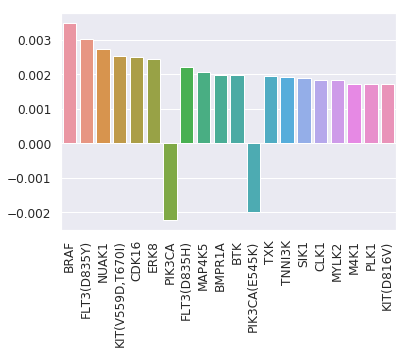

In [308]:
# Visualize k most important drug feats
k = 20
sns.barplot(x=[x[0] for x in drug_attributions[:k]], y=[x[1] for x in drug_attributions[:k]])
plt.xticks(rotation=90)
plt.show()

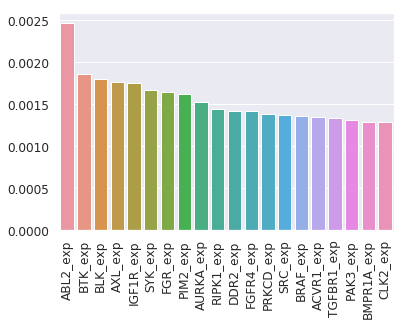

In [309]:
# Visualize k most important cl feats
k = 20
sns.barplot(x=[x[0] for x in cl_attributions[:k]], y=[x[1] for x in cl_attributions[:k]])
plt.xticks(rotation=90)
plt.show()

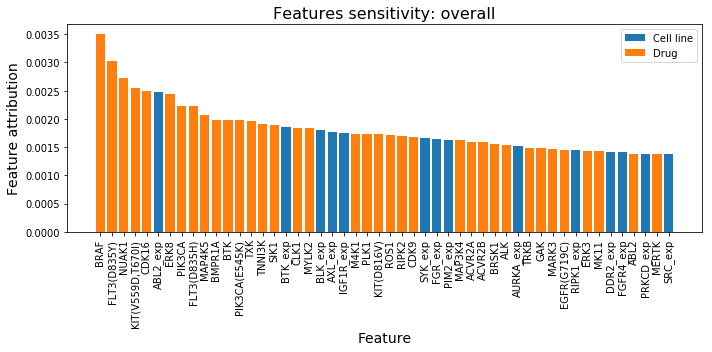

In [51]:
# Visualize top k important features (cell lines and drugs feats) across all samples
k = 50
all_features_attributions = sorted(all_features_attributions, key=lambda x: abs(x[1]), reverse=True)


names = []
x_pos = []
x_pos_cl = []
cl_attr = []

x_pos_drug = []
drug_attr = []
for i in range(k):
    feat = [x[0] for x in all_features_attributions[:k]][i]
    if feat.endswith("exp") or feat.endswith("mut") or feat.startswith("Tissue"):
        x_pos_cl.append(i)
        cl_attr.append([abs(x[1]) for x in all_features_attributions[:k]][i])
    else:
        x_pos_drug.append(i)
        drug_attr.append([abs(x[1]) for x in all_features_attributions[:k]][i])
    x_pos.append(i)
    
plt.figure(figsize=(10, 5))
plt.title("Features sensitivity: overall", fontsize=16)
plt.bar(x_pos_cl, cl_attr, label="Cell line")
plt.bar(x_pos_drug, drug_attr, label="Drug")

plt.ylabel("Feature attribution", fontsize=14)
plt.xlabel("Feature", fontsize=14)
plt.xticks(x_pos, [x[0] for x in all_features_attributions[:k]], rotation=90)

plt.legend()
plt.tight_layout()

plt.savefig("feat_importances_exp" + str(experiment) + ".pdf")
plt.show()

#### Sensitivity analysi for a given drug


In [45]:
# Sensitivity analysi for a given drug
# Integrated Gradients
ig = IntegratedGradients(net)

drug_id = 1373

# Establish samples on which to compute importances
samples  = samples_train_and_val[samples_train_and_val["DRUG_ID"] == drug_id]

cl_input = torch.from_numpy(cell_line_data_df.loc[samples["COSMIC_ID"].values].values).float()
drug_input = torch.from_numpy(drug_data_df.loc[samples["DRUG_ID"].values].values).float()

cl_input.requires_grad_()
drug_input.requires_grad_()

attributions, delta = ig.attribute((drug_input, cl_input), return_convergence_delta=True)
drug_attributions, cl_attributions = attributions
drug_attributions = drug_attributions.detach().numpy()
cl_attributions = cl_attributions.detach().numpy()

print(drug_attributions.shape, drug_attributions.sum())
print(cl_attributions.shape, cl_attributions.sum())

drug_attributions = np.mean(drug_attributions, axis=0)
cl_attributions = np.mean(cl_attributions, axis=0)

print(drug_attributions.shape, drug_attributions.sum())
print(cl_attributions.shape, cl_attributions.sum())

drug_attributions = [x for x in zip(list(drug_data_df.columns), drug_attributions)]
cl_attributions = [x for x in zip(list(cell_line_data_df.columns), cl_attributions)]

all_features_attributions = drug_attributions + cl_attributions
# Sort by importance
drug_attributions = sorted(drug_attributions, key=lambda x: abs(x[1]), reverse=True)
cl_attributions = sorted(cl_attributions, key=lambda x: abs(x[1]), reverse=True)

(735, 294) 120.532486
(735, 241) 141.48064
(294,) 0.16398977
(241,) 0.19249067


In [46]:
len(all_features_attributions)

535

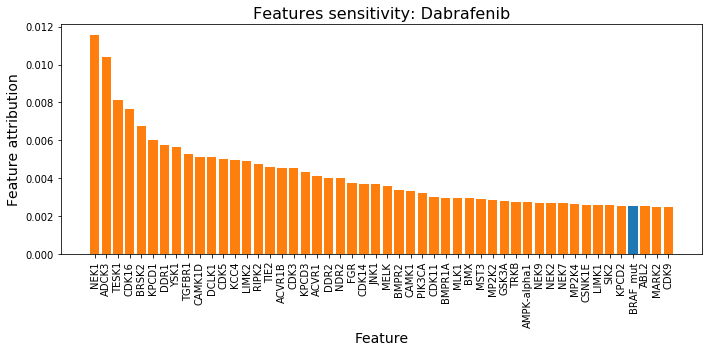

In [48]:
# Visualize top k important features (cell lines and drugs feats) across all samples
k = 50
all_features_attributions = sorted(all_features_attributions, key=lambda x: abs(x[1]), reverse=True)

names = []
x_pos = []
x_pos_cl = []
cl_attr = []

x_pos_drug = []
drug_attr = []
for i in range(k):
    feat = [x[0] for x in all_features_attributions[:k]][i]
    if feat.endswith("exp") or feat.endswith("mut") or feat.startswith("Tissue"):
        x_pos_cl.append(i)
        cl_attr.append([abs(x[1]) for x in all_features_attributions[:k]][i])
    else:
        x_pos_drug.append(i)
        drug_attr.append([abs(x[1]) for x in all_features_attributions[:k]][i])
    x_pos.append(i)
    
plt.figure(figsize=(10, 5))
plt.title("Features sensitivity: Dabrafenib", fontsize=16)
plt.bar(x_pos_cl, cl_attr, label="Cell line")
plt.bar(x_pos_drug, drug_attr, label="Drug")

plt.ylabel("Feature attribution", fontsize=14)
plt.xlabel("Feature", fontsize=14)
plt.xticks(x_pos, [x[0] for x in all_features_attributions[:k]], rotation=90)

#plt.legend()
plt.tight_layout()

# plt.savefig("feat_importances_exp_Dabrafenib.pdf")
plt.show()

### Relationship between code dimensions and input features (Neuron Attributions)

#### For drugs

In [ ]:
def net(drug_input):
    return model.network.drug_autoencoder(drug_input)[0]

k = 10  # How many samples use to compute importances
drug_input = torch.from_numpy(drug_data_df.values).float()[:k]
drug_input.requires_grad_()

# Integrated Gradients
ig = IntegratedGradients(net)

drug_code_attributions, delta = ig.attribute(drug_input, target=9,  return_convergence_delta=True)
drug_code_attributions = drug_code_attributions.detach().numpy()
drug_code_attributions = np.mean(drug_code_attributions, axis=0)

# Compute drug code attributions for every dimension in code space
drug_code_attributions_df = pd.DataFrame()
for dim in range(model.network.drug_autoencoder(drug_input[0])[0].shape[0]):
    code_attributions, delta = ig.attribute(drug_input, target=dim,  return_convergence_delta=True)
    code_attributions = code_attributions.detach().numpy()
    code_attributions = np.mean(code_attributions, axis=0)
    
    drug_code_attributions_df[dim] = code_attributions
drug_code_attributions_df.index = drug_data_df.columns
print(drug_code_attributions_df.shape)
drug_code_attributions_df.head()

In [ ]:
# Visualize the codes attributions on heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(drug_code_attributions_df, yticklabels=5)

plt.savefig("heatmap.pdf")
plt.show()

#### For cell lines